In [2]:
# Installing packages needed
import sys
def pip_install(pkgs):
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', *pkgs])

try:
    import pyspark  # noqa
    import pandas as pd  # noqa
    import numpy as np  # noqa
except Exception:
    pip_install(['pyspark==3.5.1','pandas','numpy','pyarrow'])
print('Packages ready.')

Packages ready.


In [4]:
# Starting Spark session
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.window import Window
spark = (SparkSession.builder
         .appName('SocialSale-EDA')
         .master('local[*]')
         .config('spark.sql.legacy.timeParserPolicy','LEGACY')
         .getOrCreate())
print('Spark version:', spark.version)

Spark version: 3.5.1


In [8]:
# Paths
BASE = r"C:\Users\Hp\Desktop\To Post"
RAW = f'{BASE}/data_raw'
EXPORTS = f'{BASE}/exports'
print(RAW)

C:\Users\Hp\Desktop\To Post/data_raw


In [10]:
from pathlib import Path
from pyspark.sql import functions as F

# Pointing to my folder
RAW = Path(r"C:\Users\Hp\Desktop\To Post\data_raw")
assert RAW.exists(), f"Folder not found: {RAW}"

RAW_POSIX = RAW.as_posix()  

# Loading datasets
events    = spark.read.option('header', True).csv(f"{RAW_POSIX}/social_events.csv")
campaigns = spark.read.option('header', True).csv(f"{RAW_POSIX}/campaigns_dim.csv")
sessions  = spark.read.option('header', True).csv(f"{RAW_POSIX}/sessions.csv")
page      = spark.read.option('header', True).csv(f"{RAW_POSIX}/page_events.csv")
orders    = spark.read.option('header', True).csv(f"{RAW_POSIX}/orders.csv")
reviews   = spark.read.option('header', True).csv(f"{RAW_POSIX}/reviews.csv")

# Cast types
events   = (events
            .withColumn('timestamp', F.to_timestamp('timestamp'))
            .withColumn('dwell_seconds', F.col('dwell_seconds').cast('int')))
sessions = (sessions
            .withColumn('start_time', F.to_timestamp('start_time'))
            .withColumn('end_time',   F.to_timestamp('end_time')))
orders   = (orders
            .withColumn('order_value', F.col('order_value').cast('double'))
            .withColumn('order_ts',    F.to_timestamp('order_ts')))
reviews  = reviews.withColumn('timestamp', F.to_timestamp('timestamp'))

print('Counts:', {
    'events': events.count(),
    'sessions': sessions.count(),
    'page_events': page.count(),
    'orders': orders.count(),
    'reviews': reviews.count()
})


Counts: {'events': 90000, 'sessions': 9948, 'page_events': 29650, 'orders': 613, 'reviews': 12000}


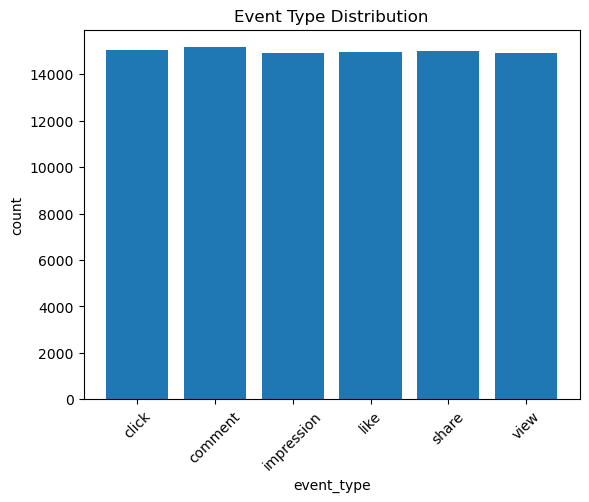

In [12]:
evt_counts = events.groupBy('event_type').count().orderBy('event_type').toPandas()
import matplotlib.pyplot as plt

plt.figure()
plt.bar(evt_counts['event_type'], evt_counts['count'])
plt.title('Event Type Distribution')
plt.xlabel('event_type'); plt.ylabel('count'); plt.xticks(rotation=45); plt.show()

## Daily visitors vs orders (line charts) and conversion rate


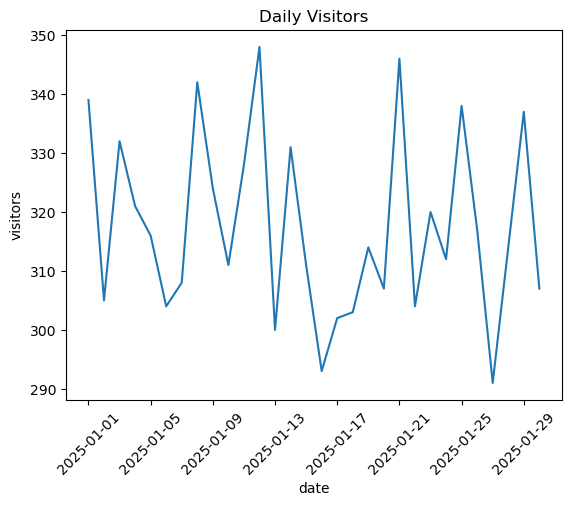

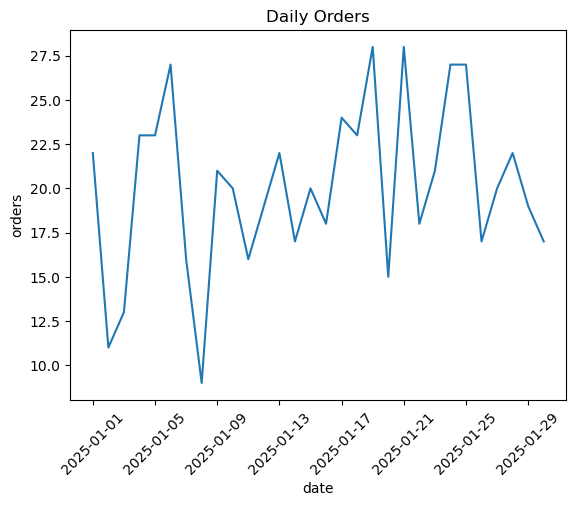

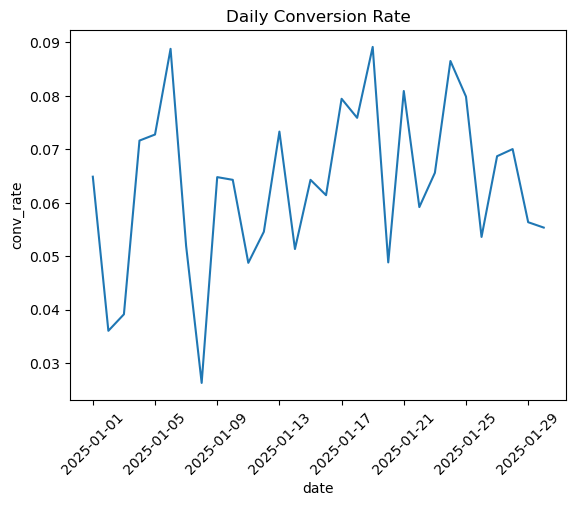

In [14]:
sessions_d = sessions.withColumn('date', F.to_date('start_time'))
visitors = sessions_d.groupBy('date').agg(F.countDistinct('user_key').alias('visitors'))
orders_d = orders.withColumn('date', F.to_date('order_ts')).groupBy('date').agg(F.count('*').alias('orders'))
daily = visitors.join(orders_d, 'date', 'left').fillna(0).orderBy('date').toPandas()
daily['conv_rate'] = daily['orders'] / daily['visitors'].replace(0, np.nan)

plt.figure()
plt.plot(daily['date'], daily['visitors'])
plt.title('Daily Visitors'); plt.xlabel('date'); plt.ylabel('visitors'); plt.xticks(rotation=45); plt.show()

plt.figure()
plt.plot(daily['date'], daily['orders'])
plt.title('Daily Orders'); plt.xlabel('date'); plt.ylabel('orders'); plt.xticks(rotation=45); plt.show()

plt.figure()
plt.plot(daily['date'], daily['conv_rate'])
plt.title('Daily Conversion Rate'); plt.xlabel('date'); plt.ylabel('conv_rate'); plt.xticks(rotation=45); plt.show()

## Brand sentiment vs conversion rate (overlayed via two plots)


In [30]:
import pandas as pd

# pick your sentiment DF variable
sd = sent_daily if 'sent_daily' in globals() else (sent_daily_pd if 'sent_daily_pd' in globals() else None)
assert sd is not None, "No sentiment dataframe found (sent_daily or sent_daily_pd)."

def to_dt64_midnight(s):
    s = pd.to_datetime(s, errors='coerce')
    # strip timezone if present
    try:
        s = s.dt.tz_convert(None)
    except Exception:
        try:
            s = s.dt.tz_localize(None)
        except Exception:
            pass
    return s.dt.normalize()

# 1) Try merging with datetime64[ns]
daily['date'] = to_dt64_midnight(daily['date'])
sd['date']    = to_dt64_midnight(sd['date'])

try:
    daily2 = daily.merge(sd, on='date', how='left').sort_values('date')
except ValueError:
    # 2) Fallback: merge on plain Python date objects (both sides same dtype)
    daily['_date_key'] = pd.to_datetime(daily['date'], errors='coerce').dt.date
    sd['_date_key']    = pd.to_datetime(sd['date'],    errors='coerce').dt.date
    daily2 = (daily.merge(sd.drop(columns=['date']).rename(columns={'_date_key':'date'}),
                          left_on='_date_key', right_on='date', how='left')
                    .drop(columns=['_date_key'])
                    .sort_values('date'))
    # convert back to datetime for plotting/rolling
    daily2['date'] = pd.to_datetime(daily2['date'])

print(daily2.dtypes[['date']])
print(daily2.head(3)[['date']])


date    datetime64[ns]
dtype: object
        date
0 2025-01-01
1 2025-01-02
2 2025-01-03


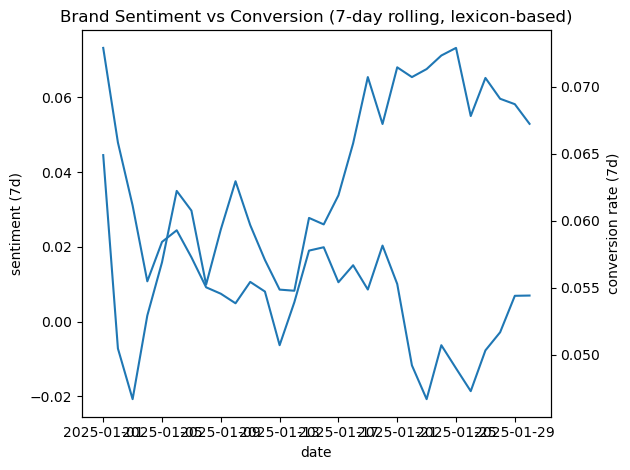

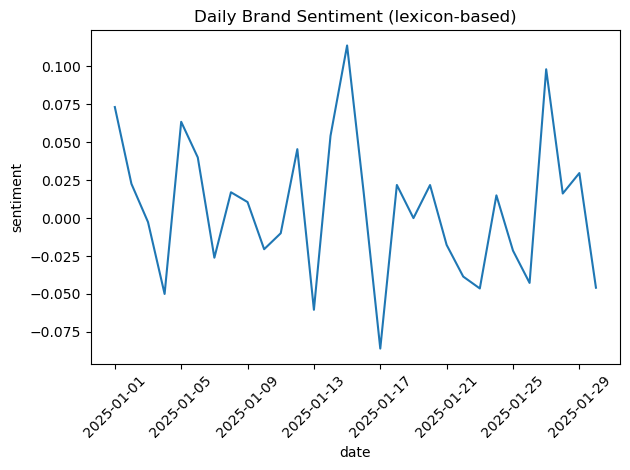

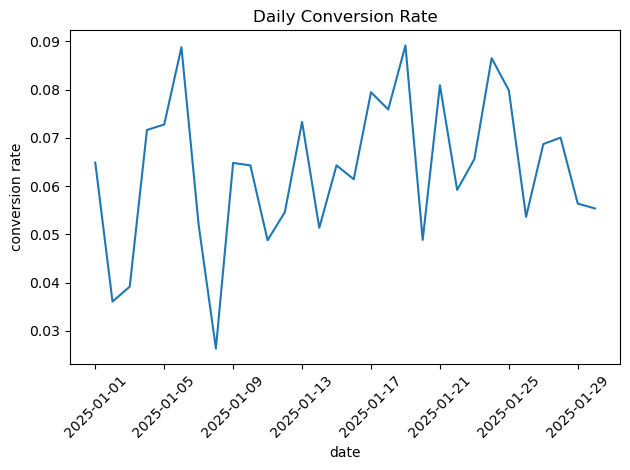

Pearson corr (same-day): -0.072


In [32]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Finding data paths
try:
    BASE = str(RAW)  # if you already set RAW earlier as a Path or string
except NameError:
    BASE = r"C:\Users\Hp\Desktop\To Post\data_raw"  # <— change if needed

#  Ensuring 'daily' exists (visitors/orders/conv_rate)
if "daily" not in globals():
    sess = pd.read_csv(os.path.join(BASE, "sessions.csv"), usecols=["user_key","start_time"])
    ords = pd.read_csv(os.path.join(BASE, "orders.csv"),   usecols=["order_ts"])

    sess["start_time"] = pd.to_datetime(sess["start_time"], errors="coerce")
    ords["order_ts"]   = pd.to_datetime(ords["order_ts"],   errors="coerce")
    sess = sess.dropna(subset=["start_time"]); ords = ords.dropna(subset=["order_ts"])

    sess["date"] = sess["start_time"].dt.normalize()
    ords["date"] = ords["order_ts"].dt.normalize()

    visitors  = (sess.groupby("date", as_index=False)["user_key"].nunique()
                    .rename(columns={"user_key":"visitors"}))
    orders_ct = (ords.groupby("date", as_index=False).size()
                    .rename(columns={"size":"orders"}))

    daily = (visitors.merge(orders_ct, on="date", how="left")
                    .fillna({"orders":0})
                    .sort_values("date"))
    daily["conv_rate"] = (daily["orders"] / daily["visitors"].replace(0, np.nan)).fillna(0)

#Loading reviews to pandas 
try:
    _ = reviews  # Spark DF exists
    rev_pd = reviews.select("timestamp","review_text").toPandas()
except Exception:
    rev_pd = pd.read_csv(os.path.join(BASE, "reviews.csv"), usecols=["timestamp","review_text"])

rev_pd["timestamp"] = pd.to_datetime(rev_pd["timestamp"], errors="coerce")
rev_pd = rev_pd.dropna(subset=["timestamp"]).copy()


# Basic positive/negative lexicons 
POS = {
    "good","great","excellent","amazing","awesome","love","loved","like","liked","happy","satisfied","fantastic",
    "perfect","best","super","wonderful","enjoy","enjoyed","recommend","recommendation","positive","wow","nice",
    "affordable","fast","quick","helpful","smooth","reliable","valuable","quality","premium","cool"
}
NEG = {
    "bad","terrible","awful","worst","hate","hated","dislike","disliked","angry","unhappy","poor","slow","buggy",
    "issue","issues","problem","problems","broken","late","delay","delayed","expensive","noisy","cheap","waste",
    "useless","crash","crashes","crashed","refund","return","negative","disappointed","disappointing"
}
NEGATORS = {"not","no","never","hardly","barely","scarcely","without","lack"}

token_re = re.compile(r"[A-Za-z']+")

def lexicon_sent(text: str) -> float:
    if not isinstance(text, str) or not text:
        return 0.0
    toks = [t.lower() for t in token_re.findall(text)]
    pos = neg = 0
    i = 0
    while i < len(toks):
        t = toks[i]
        # simple negation handling for the next token
        if t in NEGATORS and i+1 < len(toks):
            nxt = toks[i+1]
            if nxt in POS: neg += 1; i += 2; continue
            if nxt in NEG: pos += 1; i += 2; continue
        # regular count
        if t in POS: pos += 1
        elif t in NEG: neg += 1
        i += 1
    tot = pos + neg
    if tot == 0:
        return 0.0
    # score in [-1, 1]
    return (pos - neg) / tot

rev_pd["brand_sentiment_lex"] = rev_pd["review_text"].fillna("").apply(lexicon_sent)

#Daily sentiment
sent_daily = (rev_pd
              .assign(date=rev_pd["timestamp"].dt.normalize())
              .groupby("date", as_index=False)["brand_sentiment_lex"].mean()
              .sort_values("date"))

# Merge with conversion 
daily2 = daily.merge(sent_daily, on="date", how="left").sort_values("date")

# smoothing for readability
if len(daily2) >= 14:
    daily2["sent_roll7"] = daily2["brand_sentiment_lex"].rolling(7, min_periods=1).mean()
    daily2["conv_roll7"] = daily2["conv_rate"].rolling(7, min_periods=1).mean()
else:
    daily2["sent_roll7"] = daily2["brand_sentiment_lex"]
    daily2["conv_roll7"] = daily2["conv_rate"]

#Plot: overlay with twin axes
fig, ax1 = plt.subplots()
ax1.plot(daily2["date"], daily2["sent_roll7"])
ax1.set_xlabel("date")
ax1.set_ylabel("sentiment (7d)", rotation=90)
ax2 = ax1.twinx()
ax2.plot(daily2["date"], daily2["conv_roll7"])
ax2.set_ylabel("conversion rate (7d)", rotation=90)
plt.title("Brand Sentiment vs Conversion (7-day rolling, lexicon-based)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Also show the two separate series
plt.figure()
plt.plot(daily2["date"], daily2["brand_sentiment_lex"])
plt.xlabel("date"); plt.ylabel("sentiment")
plt.title("Daily Brand Sentiment (lexicon-based)")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

plt.figure()
plt.plot(daily2["date"], daily2["conv_rate"])
plt.xlabel("date"); plt.ylabel("conversion rate")
plt.title("Daily Conversion Rate")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

#Quick correlation
aligned = daily2[["brand_sentiment_lex","conv_rate"]].dropna()
corr = aligned.corr().iloc[0,1] if not aligned.empty else np.nan
print(f"Pearson corr (same-day): {corr:.3f}")


## Interest bucket conversion (bar chart)


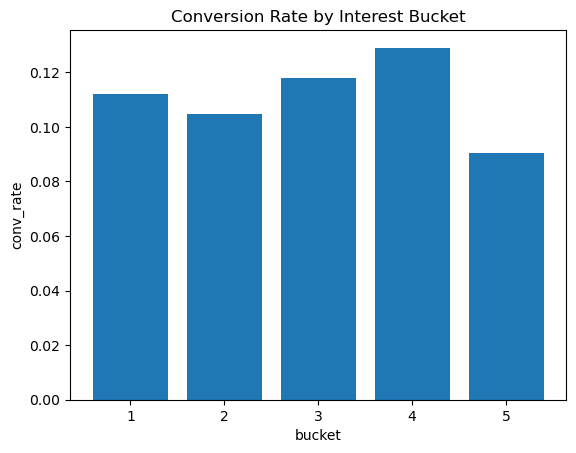

In [18]:
events_d = events.withColumn('date', F.to_date('timestamp'))
wmap = F.create_map([F.lit('click'),F.lit(3.0),F.lit('comment'),F.lit(2.0),F.lit('share'),F.lit(2.0),F.lit('like'),F.lit(1.0),F.lit('view'),F.lit(1.0),F.lit('impression'),F.lit(0.2)])
events_d = events_d.withColumn('interest', F.coalesce(wmap[F.col('event_type')],F.lit(0.0)) + F.least(F.col('dwell_seconds'),F.lit(60))/60.0*0.5)
user_day = events_d.groupBy('user_key','campaign_id','date').agg(F.sum('interest').alias('raw_interest'))
w = Window.partitionBy('campaign_id')
user_day = user_day.withColumn('interest_score', (F.col('raw_interest')-F.min('raw_interest').over(w)) / (F.max('raw_interest').over(w)-F.min('raw_interest').over(w) + F.lit(1e-6)))
w2 = Window.partitionBy('campaign_id').orderBy('date')
user_day_b = user_day.withColumn('bucket', F.ntile(5).over(w2))
od = orders.select('user_key', F.to_date('order_ts').alias('order_date'))
u = user_day_b.join(od, 'user_key', 'left').withColumn('purchased_in_3d', F.when((F.col('order_date')>=F.col('date')) & (F.col('order_date')<=F.date_add(F.col('date'),3)), 1).otherwise(0))
ic = u.groupBy('bucket').agg(F.countDistinct('user_key').alias('users'), F.sum('purchased_in_3d').alias('purchases')).withColumn('conv_rate', F.col('purchases')/F.col('users')).orderBy('bucket').toPandas()

plt.figure()
plt.bar(ic['bucket'].astype(str), ic['conv_rate'])
plt.title('Conversion Rate by Interest Bucket'); plt.xlabel('bucket'); plt.ylabel('conv_rate'); plt.show()

## Top campaigns by ROAS (bar chart)


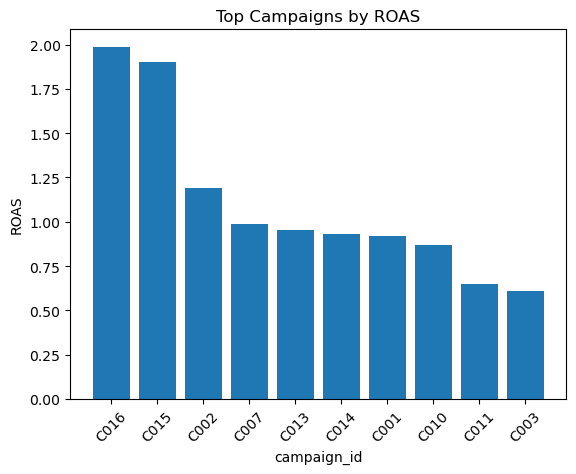

In [20]:
last_sess = sessions.withColumn('rn', F.row_number().over(Window.partitionBy('user_key').orderBy(F.col('start_time').desc())))\
                   .filter('rn=1').select('user_key','campaign_id')
att = orders.join(last_sess, 'user_key', 'left').groupBy('campaign_id').agg(F.count('*').alias('orders'), F.sum('order_value').alias('revenue'))
att = att.join(campaigns.select('campaign_id','spend'), 'campaign_id', 'left').withColumn('ROAS', F.col('revenue')/F.col('spend'))
att_pd = att.orderBy(F.desc('ROAS')).limit(10).toPandas()

plt.figure()
plt.bar(att_pd['campaign_id'], att_pd['ROAS'])
plt.title('Top Campaigns by ROAS'); plt.xlabel('campaign_id'); plt.ylabel('ROAS'); plt.xticks(rotation=45); plt.show()

In [35]:
# Stop Spark
spark.stop()
print('Done.')

Done.
